# Signal Resolution Enhancement by Derivative Transformation

Following on from [preprocessing_1_smoothing_sharpening_2](./preprocessing_1_smoothing_sharpening_1.ipynb), where we developed various transformers, visualisation APIs and handled floating point precision, we will now attempt to produce a clean signal. To do so we need to optimize the use of signal transformation via derivatives. This notebook investigates the effects of addition or subtraction of the various derivatives, as well as chained transformations.


### Subtraction of Weighted Second Derivative

We will recall from the previous notebook that the subtraction of the weighted second derivative is defined as: $$R_j=Y_j-k_2Y"$$

where $R_j$ is the enhanced signal, $Y_j$ is the original signal, $Y"$ is the second derivative of $Y_j$, $k_2$ is the seond derivative weighting factor.

In [4]:
from dataclasses import dataclass
from findiff import FinDiff
from hplc_py.definitions import PRECISION
from hplc_py.pipeline.preprocess_dashboard import DataSets, PreProcesser
from pandera.typing.polars import DataFrame, LazyFrame
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

import holoviews as hv
import hvplot
import numpy as np
import pandera as pa
import panel as pn
import polars as pl

%reload_ext autoreload
%autoreload 2

pl.Config.set_fmt_float(fmt="full")
pl.Config.set_tbl_rows(10)

hv.renderer("bokeh").theme = "dark_minimal"

dsets = DataSets()
ringland = dsets.ringland.fetch().with_columns(
    pl.col("time").round(9), pl.col("signal").round(9)
)
ringland.head()

ImportError: cannot import name 'DataSets' from 'hplc_py.pipeline.preprocess_dashboard' (/Users/jonathan/hplc-py/hplc_py/pipeline/preprocess_dashboard.py)

#### First Finite Difference

We will use the FinDiff package for calculating our finite differences - it is better to use third-party packages (which are still supported) as they cover edge cases, testing, validation etc. While the docs dont explicitely state it, it is clear that they use the central finite difference for intermediate values, the foreward for the first value, and back for the last. See: [FinDiff Theory](https://findiff.readthedocs.io/en/latest/source/theory.html)

In [ ]:
dx = data.select(pl.col("time").diff().mean()).item()
dx

0.006666666666831317

In [ ]:
d1 = FinDiff(0, dx, 1)

data = data.pipe(
    lambda df: df
    .with_columns(
        pl.Series(name='d1', values=d1(
            df.select("signal").to_series().to_numpy()
        )).round(PRECISION)
    )
)  # fmt: skip
display(data)

time,signal,d1
f64,f64,f64
0.005833333,0.001952052,-0.04190955
0.0125,0.001825392,0.00391155
0.019166667,0.002004206,0.077672325
0.025833333,0.002861023,0.146962725
0.0325,0.003963709,0.1620501
…,…,…
26.9725,1.733087003,-0.13634565
26.979166667,1.732110977,-0.149197875
26.985833333,1.731097698,-0.146962725


In [ ]:
data = ringland.select(
    pl.col("time").round(PRECISION), pl.col("signal").round(PRECISION)
)
data

NameError: name 'ringland' is not defined

In [ ]:
d1_viz = (
    data.with_columns(pl.col("d1").mul(0.1))
    .plot(x="time", y=["signal", "d1"], alpha=[1, 0.6], line_dash=["solid", "dotdash"])
    .opts(
        height=500, width=750, title="signal and first finite difference", xlim=(0, 5)
    )
)
display(d1_viz)

NameError: name 'data' is not defined

#### First Finite Difference

We will use the FinDiff package for calculating our finite differences - it is better to use third-party packages (which are still supported) as they cover edge cases, testing, validation etc. While the docs dont explicitely state it, it is clear that they use the central finite difference for intermediate values, the foreward for the first value, and back for the last. See: [FinDiff Theory](https://findiff.readthedocs.io/en/latest/source/theory.html)

BokehModel(combine_events=True, render_bundle={'docs_json': {'652d9903-b58d-4473-a5e7-c6934765760f': {'version…

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
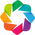

idx,detection,color,varietal,id,code_wine,time,signal
i64,str,str,str,str,str,f64,f64
0,"""raw""","""red""","""shiraz""","""7b085f32-4d69-…","""a0301_2021 chr…",0.0058,0.0020
1,"""raw""","""red""","""shiraz""","""7b085f32-4d69-…","""a0301_2021 chr…",0.0125,0.0018
2,"""raw""","""red""","""shiraz""","""7b085f32-4d69-…","""a0301_2021 chr…",0.0192,0.0020
3,"""raw""","""red""","""shiraz""","""7b085f32-4d69-…","""a0301_2021 chr…",0.0258,0.0029
4,"""raw""","""red""","""shiraz""","""7b085f32-4d69-…","""a0301_2021 chr…",0.0325,0.0040


In [ ]:
from dataclasses import dataclass

import holoviews as hv
import hvplot
import numpy as np
import pandera as pa
import panel as pn
import polars as pl
from findiff import FinDiff
from sklearn.compose import ColumnTransformer

from hplc_py.baseline_correction import baseline_correction
from hplc_py.datasets import DataSets
from hplc_py.definitions import PRECISION
from hplc_py.map_signal import map_signal

pl.Config.set_fmt_float(fmt="mixed").set_float_precision(4).set_tbl_rows(10)
hv.extension("bokeh", inline=False)
hv.renderer("bokeh").theme = "dark_minimal"

dsets = DataSets()
ringland = dsets.ringland.fetch().with_columns(
    pl.col("time").round(9), pl.col("signal").round(9)
)

%reload_ext autoreload
%autoreload 2

from sklearn.pipeline import Pipeline

from hplc_py import transformers

ringland.head()

## Observations of the Effects of Signal Resolution via Finite Difference Addition and Subtraction 

A signals peak resolution can be manipulated by the addition and subtraction of its derivatives. It is routine to add the first derivative, and subtract the second, but common to encounter higher order operations in the literature.

#### First Order Addition

The first order addition is displayed below:

In [ ]:
fin_diff_data = ringland.select("signal")
fin_diff_data

signal
f64
0.0020
0.0018
0.0020
0.0029
0.0040
…
1.7331
1.7321
1.7311


In [ ]:
first_order_diff_add = transformers.FirstOrderFiniteDiffAddition(k=4).set_output(
    transform="polars"
)
display(first_order_diff_add.fit_transform(X=fin_diff_data))

first_order_diff_add.plot().opts(
    show_grid=True,
    height=400,
    width=1200,
    xlim=(120, 220),
    ylim=(-50, 150)
)  # fmt: skip

signal
f64
0.0008
0.0019
0.0041
0.0068
0.0083
…
1.7295
1.7281
1.7272


:NdOverlay   [Variable]
   :Curve   [index]   (value)

As we can see, the first derivative of the signal is centered on zero. Traversing the signal space along the time axis from t = 0, we observe that the derivative is zero when the signal is flat, but when we reach the left side of a peak, the derivative rises in peak-like fashion also, becoming sharper until the peak inflection point is reached, that is, where it begins to level off. This is the derivative peak's maxima. After this the derivaive drops sharply, and is zero at the signal peak maxima. Descending down the right side of the peak, the derivative is below zero, reaching its minima at the lowest point of resolution of the peak from the baseline, after which the signal levels off to flatness, and the derivative reaches zero. As the next peak is approached, the derivative again moves toward infinity, rising until the next peak inflection point is reached, and so on.

The key take aways are that the first derivative mimics the shape of the signal, however its peaks are centered on the signal peaks inflection points, thus depending on the normality of the peak, they will generally be centered half a peak to the left of the original. It follows then that addition of the derivative to the signal will shift the transformed signal leftward to a location between the original signal peak and the first derivative peak. Also, the derivative contains negative values on the right side of peaks, thus if $k$ is too high, addition of the derivative will cause the transformed signal to drop below the baseline (if the baseline is zero).

#### First Order Subtraction

In [ ]:
first_order_sub = transformers.FiniteDiffAdder(order=1, dx=1, k=4, sign="-")
first_order_sub.fit_transform(X=fin_diff_data)
first_order_sub.plot().opts(
    show_grid=True, height=400, width=1200, xlim=(120, 220), ylim=(-50, 150)
)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

Alternatively, subtraction of the first derivative causes the signal to shift right, and has a much larger effect than addition for the same weighting, peaks are much more resolved, but consequently the signal goes further below the baseline too.

#### Second Derivative Addition

Another common operation is the subtraction of the second derivative:

In [ ]:
second_order_add = transformers.FiniteDiffAdder(order=2, dx=1, k=4, sign="-")
second_order_add.fit_transform(X=fin_diff_data)
second_order_add.plot().opts(
    show_grid=True,
    xlim=(120, 220),
    ylim=(-50, 150),
    height=400,
    width=1200,
)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

Observing the transformation in the same time-oriented manner as before we can see that the second derivative is almost the inverse of the signal, decreasing on the left side of a peak and increasing on the right, with local minima where a signal has a local maxima. Thus the subtraction magnifies peaks without modifying their time location, and affects the already sharpest peaks the most. It can however distort the shape of peaks

Now how do the third and fourth derivatives compare?

#### Third and Fourth Derivative Transformations

In [ ]:
# get the first four derivatives and overlay the plots on the original signal
from typing import Self


class DerivativePlots:
    def __init__(self, findiff_kwargs: list[dict[str, str | int]]):
        """
        Derivative calculations of a 1d array X.

        For a mapping of derivative order, weighting "k", and transformation "sign"
        ("-" or "+") calculate the derivative, weighted derivative (derivative * "k"), and X
        transformation "X_", organising the results into an iterable table `tbl_deriv`.

        Also provides the option to plot an overlay of X and the calculated weighted
        derivatives through `plot_derivative_overlay` and a tabbed visualisation of X, each
        weighted derivative, and X_ through `plot_transformation_overlay`.

        Uses Holoviews for visualisations, the output of which are `holoviews.NdLayout` objects
        whose settings are accessed via `.opts` after initialisation. Refer to
        `holoviews.help(holoviews.NdLayout)` for options.
        """
        if not isinstance(findiff_kwargs, list):
            raise TypeError("findiff_kwargs must be list")

        for kwarg in findiff_kwargs:
            if not isinstance(kwarg, dict):
                raise TypeError(
                    "each element of `findiff_kwargs` must be a dict corresponding to"
                    "the args of FinDiffAdder"
                )

        self.findiff_kwargs = findiff_kwargs

    def generate_tbl(self, X: pl.DataFrame) -> Self:
        """
        for an input 1 column polars Dataframe "X", generate a long deriative table
        consisting of the following columns (from left to right):
         - x "idx"
         - derivative "order"
         - input "X"
         - weighting "k"
         - the derivative "diff",
         - weighted deriative "diff_weighted"
         - the transformed signal "X_".

        with length equal to the length of "X". the "order" and "k" columns are scalars.

        For each key value pair in `order_weighting_map`, this function generates the
        above table and then vertically stacks one after the other such that the result is a
        long frame grouped by the order integer.

        Finally, it stores the table internally, returning self. To access the table
        directly, access 'tbl_deriv' afterwards

        >>> X = pl.DataFrame(dict(X=[1,2,5,20,5,2,1]))
        >>> findiff_kwarg_mapping = {1: {"sign":"+"}, k:10}
        >>> deriv_plots = DerivPlots(findiff_kwarg_mapping=findiff_kwarg_mapping)
        >>> tbl_deriv = deriv_plots.generate_tbl(X=X).tbl_deriv
        """
        if not isinstance(X, pl.DataFrame):
            raise TypeError("Please input a Polars DataFrame")

        if len(X.columns) > 1:
            raise ValueError("Please input a 1 column Polars DataFrame")

        dfs = []
        for kwargs in self.findiff_kwargs:
            order = kwargs["order"]
            sign = kwargs["sign"]

            tformer = transformers.FiniteDiffAdder(**kwargs)
            tformer.fit_transform(X=X)
            df = tformer.data_as_frame.with_columns(
                pl.lit(order).alias("order"), pl.lit(sign).alias("sign")
            )
            dfs.append(df)

        self.tbl_deriv = pl.concat(dfs)

        return self

    def plot_derivative_overlay(self) -> hv.NdLayout:
        """
        returns a holoviews overlay of each weighted derivative of X and X.

        The derivatives are calculated according to the arguments provided in
        `findiff_kwarg_mapping`, with weighting 'k'.

        if `tbl_deriv` has not already been called, calling this method will result in
        a `RuntimeError`.

        >>> X = pl.DataFrame(dict(X=[1,2,5,20,5,2,1]))
        >>> findiff_kwarg_mapping = {1: {"sign":"+"}, k:10}
        >>> deriv_plots = DerivPlots(findiff_kwarg_mapping=findiff_kwarg_mapping)
        >>> tbl_deriv = deriv_plots.generate_tbl(X=X).tbl_deriv
        >>> plot = deriv_plots.generate_tbl(X=X).plot_derivative_overlay()
        >>> plot # in notebook

        or

        >>> hvplot.show(plot) # in script

        As with all holoviews Layouts, the `.opts` method can be used to set layout
        options, and change from tabbed to grid layout, etc.
        """

        if not hasattr(self, "tbl_deriv"):
            raise RuntimeError("run `self.generate_tbl` first")

        derivative_plot = self.tbl_deriv.plot(
            x="idx",
            y="diff_weighted",
            by="order",
            line_alpha=[0.75, 0.75, 0.75, 0.75],
            label="order",
            line_dash=["dotted", "dashdot", "dotdash", "dashed"],
        )

        # get the X of the first order by entry from `tbl_deriv`

        # first_order_key = list(self.findiff_kwarg_mapping.keys())[0]

        X = self.tbl_deriv.partition_by(["order", "sign"], maintain_order=True)[0]

        X_plot = X.plot(x="idx", y="X", label="X")

        deriv_overlay = X_plot * derivative_plot
        return deriv_overlay.opts(
            title="derivative_overlay",
        )

    def plot_transformation_overlay(self):
        """
        create a tabbed overlay of each orders weighted derivative "diff_weighted", X, and the
        resulting transformation according to the sign in `findiff_kwarg_mapping`, either
        adding or subtracting `diff_weighted` to/from X.

        >>> X = pl.DataFrame(dict(X=[1,2,5,20,5,2,1]))
        >>> findiff_kwarg_mapping = {1: {"sign":"+"}, k:10}
        >>> deriv_plots = DerivPlots(findiff_kwarg_mapping=findiff_kwarg_mapping)
        >>> tbl_deriv = deriv_plots.generate_tbl(X=X).tbl_deriv
        >>> plot = deriv_plots.generate_tbl(X=X).plot_transformation_overlay()
        >>> plot # in notebook

        or

        >>> hvplot.show(plot) # in script

        As with all holoviews Layouts, the `.opts` method can be used to set layout
        options, and change from tabbed to grid layout, etc.
        """

        deriv_plots = {}
        for key, df in self.tbl_deriv.partition_by(
            by=["order", "sign"], as_dict=True, maintain_order=True
        ).items():
            plot = df.plot(
                x="idx",
                y=["X", "diff_weighted", "X_"],
                line_alpha=[1, 0.75, 0.75],
                line_dash=["solid", "dotted", "dashed"],
                grid=True,
            )

            # to modify the legend to include the sign in the X_ entry
            # 1. using hooks https://stackoverflow.com/questions/64744222/holoviews-ndoverlay-legend

            deriv_plots[key] = plot

        deriv_plot_layout = hv.NdLayout(deriv_plots, kdims=["order", "sign"]).opts(
            tabs=True, width=1000, height=1000
        )

        return deriv_plot_layout


order_weighting_map = [
    {"order": 1, "sign": "+", "k": 7},
    {"order": 2, "sign": "-", "k": 15},
    {"order": 3, "sign": "+", "k": 20},
    {"order": 4, "sign": "+", "k": 25},
]
data = (
    fin_diff_data.with_row_index("idx")
    .filter(pl.col("idx").ge(120), pl.col("idx").le(220))
    .drop("idx")
)

derivative_plotter = DerivativePlots(findiff_kwargs=order_weighting_map)
derivative_plotter.generate_tbl(X=data).plot_derivative_overlay().opts(
    show_grid=True, height=700, width=1000
)

:Overlay
   .Curve.X         :Curve   [idx]   (X)
   .NdOverlay.Order :NdOverlay   [order]
      :Curve   [idx]   (diff_weighted)

Note to reader: compare the different derivatives by muting the others via the legend.

3rd derivative: the third derivative tracks the second, but the peaks are shifted left. Relative to the signal, the left side of the peak is 

In [ ]:
derivative_plotter.plot_transformation_overlay()

:NdLayout   [order,sign]
   :NdOverlay   [Variable]
      :Curve   [idx]   (value)

Note to reader: cycle through each tab in the above widget to observe how the different deriatives affect the signal.

A key takeway is that the position of the negative portion of the signal derivative affects the signal and determines whether we should add or subtract it. if, like the second derivative, it is positive at the peak base x and negative at the peak maxima x, then we should subtract it in order to boost the peak maxima and minimise the peak bases. However, if like the 4th derivative, it is negative at the peak bases and positive at the peak maxima, then we should add it for the same effect. Note that even derivatives are in sync with the peak, but odd derivatives are shifted half a peak, with the first derivative to the left, and the third derivative to the right.

What about the 5th and 6th derivatives? does that pattern hold?

In [ ]:
order_weighting_map_2 = [
    {"order": 5, "sign": "+", "k": 50},
    {"order": 6, "sign": "+", "k": 50},
]

deriv_plotter_2 = DerivativePlots(findiff_kwargs=order_weighting_map_2).generate_tbl(
    X=data
)
display(
    deriv_plotter_2.plot_derivative_overlay().opts(
        show_grid=True, width=1000, height=500
    )
)

:Overlay
   .Curve.X         :Curve   [idx]   (X)
   .NdOverlay.Order :NdOverlay   [order]
      :Curve   [idx]   (diff_weighted)

As we can see in the plot above, the derivative signals are beginning to increase in noise and roughness, becoming more sensitive to irregularities in the orignal signal. Comparing the odd derivatives:

In [ ]:
even_derivatives = [
    {"order": 1, "sign": "+", "k": 4},
    {"order": 1, "sign": "-", "k": 4},
    {"order": 3, "sign": "+", "k": 20},
    {"order": 3, "sign": "-", "k": 20},
    {"order": 5, "sign": "+", "k": 40},
    {"order": 5, "sign": "-", "k": 40},
]

deriv_plotter_3 = DerivativePlots(findiff_kwargs=even_derivatives).generate_tbl(
    X=fin_diff_data
)

deriv_plotter_3.plot_derivative_overlay().opts(
    show_grid=True,
    xlim=(120, 220),
    ylim=(-100, 150),
    width=1000,
    height=500,
    title="odd derivatives overlaid",
)

:Overlay
   .Curve.X         :Curve   [idx]   (X)
   .NdOverlay.Order :NdOverlay   [order]
      :Curve   [idx]   (diff_weighted)

There is an evident alternation in the peak and trough locations, but also increasing levels of noise as small imperfectins in the signal are magnified, evident in the peak between 180 - 190nm. and the transformation:

In [ ]:
xlim = (120, 220)
ylim = (-100, 200)

tform_overlay_3 = deriv_plotter_3.plot_transformation_overlay()
t = hv.NdLayout(
    {k: v.opts(xlim=xlim, ylim=ylim) for k, v in tform_overlay_3.items()},
    kdims=["order", "sign"],
)
t.opts(tabs=True)

:NdLayout   [order,sign]
   :NdOverlay   [Variable]
      :Curve   [idx]   (value)

the subtraction of the peak between 157 and 177 is positively skewed when subtracting the 5th derivative, and negatively skewed when adding it. Furthermore the subtraction adds two peaks that were not there previously, at the bases of X. Furthermore a lot of noise (in the form of peaks) is added. The same effect, but in lower magnitude, is seen in the transformations involving the third derivative.

The effect of adding peaks and skewing indicates that the 3rd and 5th derivatives are unsuitable for routine signal transformation.

The 1st is vindicated, but only the addition, which appears to make all peaks more gaussian while maintaining the signal profile. The subtraction adds noise and adds peaks where none were previously.

In [ ]:
# even derivatives

even_derivatives = [
    {"order": 2, "sign": "+", "k": 4},
    {"order": 2, "sign": "-", "k": 4},
    {"order": 4, "sign": "+", "k": 20},
    {"order": 4, "sign": "-", "k": 20},
    {"order": 6, "sign": "+", "k": 40},
    {"order": 6, "sign": "-", "k": 40},
]

even_deriv_plots = DerivativePlots(findiff_kwargs=even_derivatives).generate_tbl(X=data)

even_deriv_plots.plot_derivative_overlay().opts(
    show_grid=True,
    width=1000,
    height=500,
    title="even derivatives overlaid",
)


even_deriv_tforms = even_deriv_plots.plot_transformation_overlay()

even_deriv_tforms.opts(tabs=True)

:NdLayout   [order,sign]
   :NdOverlay   [Variable]
      :Curve   [idx]   (value)

In what is becoming a trend, we can see that as the order increases, the noise present in the signal is amplified, and the original "real" peaks are lost amongst those created by the transformations. the addition of the 6th in particular dissolves the orignal signal into a series of almost regular peaks.

Thus overall it is evident that venturing beyond the second derivative has questionable value, especially for high k values. It may be beneficial, however, to match different order derivatives who balance the ill-effects of each other. According to the literature, the subtraction of the second followed by addition of the fourth provides better results than the addition of the second alone (See: [A Pragmatic Introduction to Signal Processing: Peak Sharpening (Resolution enhancement)](https://terpconnect.umd.edu/~toh/spectrum/ResolutionEnhancement.html)), Lets observe it for ourselves.

In [ ]:
# get the first and fourth derivatives, subtract the second, add the fourth


def sub_second_add_fourth(X, k_2, k_4):
    findiff_2 = transformers.FiniteDiffAdder(order=2, k=k_2).set_output(
        transform="polars"
    )
    findiff_2.fit_transform(X)

    findiff_4 = transformers.FiniteDiffAdder(order=4, k=k_4).set_output(
        transform="polars"
    )
    findiff_4.fit_transform(X)

    deriv_2 = findiff_2.data_as_frame.select(
        pl.col("diff_weighted").alias("diff_weighted_2")
    )
    deriv_4 = findiff_4.data_as_frame.select(
        pl.col("diff_weighted").alias("diff_weighted_4")
    )

    df = pl.concat([X.rename({"signal": "X"}), deriv_2, deriv_4], how="horizontal")
    df = df.with_columns(
        pl.col("X")
        .sub(pl.col("diff_weighted_2"))
        .add(pl.col("diff_weighted_4"))
        .alias("X_")
    )
    return df.plot(y=["X", "X_"], title='$X_=X - X"" + X""""$')


sub_second_add_fourth(X=data, k_2=4, k_4=5).opts(show_grid=True)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [ ]:
even_deriv_tforms.get((2, "-"))

:NdOverlay   [Variable]
   :Curve   [idx]   (value)

Observing the difference between the above two plots, the effect of introducing the 4th derivative is not noticible enough to justify the added complexity, and in fact increasing the 4th derivative only serves to increase the noise.

## Observations from "A Pragmatic Introduction to Signal Processing: Differentiation"

Prof. O'Haver dictates the the following patterns for a smooth peak of a single maximum:
- its sequential derivatives will have a series of alternating maxima and minima, one more than the derivative order.
- even order derivatives have a maximum or minimum at the peak center
- odd order derivatives have a zero crossing at the peak center
- derivative overall magnitude become smaller as the derivative order increases

He also notes that the peak width is an important predictor of the amplitude of the derivative. Wider peaks have smaller derivative amplitude as the peak amplitude decreases more slowly than a sharper peak, an effect that increases as derivative order increases. Consequently, it can be shown that the "nth derivative of a peak is inversely proportional to the nth power of its width". The result is that transformation by derivative addition / subtraction is more acute when involving sharper peaks than wider ones. Thus, if looking to sharpen all peaks equally, a varying weighting with respect to time may be desirable.

Source: [ohaver2023](https://terpconnect.umd.edu/~toh/spectrum/Differentiation.html)

## Conclusion

Stick with subtraction of first derivative, addition of second. If we need more fine tuned resolution through this method, it may be necessary to enact a method of including a varying $k$ rather than a scalar. The difficulty would be how to fine tune that process. Potentially an initial windowing then weighting to window mapping. You could even map the peaks initially, then target the widest ones with the highest k, resolve, then check again in a recursive manner. K in respect to peak width.